# The purpose of this notebook is to get data from multiple data sources and transform them to common structure.

In [178]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [179]:
# VARIABLES
pd.options.mode.chained_assignment = None
DF_MERGED_DELETE_OUTLIERS = True

In [180]:
def text_analysis(df):
    """
    counts: capital letters, small letters, special characters, blank signs, numbers, letters (small + capital)
    """
    nan_titles = df.isnull().values.any() 
    print(f"\nNaN titles dropped: { nan_titles }")
    df = df.dropna(subset=['title'])
    
    df["char_capital"] = df["title"].apply(lambda title: sum(1 for char in title if char.isupper()))
    df["char_small"] = df["title"].apply(lambda title: sum(1 for char in title if char.islower()))
    df["char_special"] = df["title"].apply(lambda title: sum(1 for char in title if not char.isalnum() and not char.isspace()))
    df["blank"] = df["title"].apply(lambda title: sum(1 for char in title if char.isspace()))
    df["numerical"] = df["title"].apply(lambda title: sum(1 for char in title if char.isdigit())) 
    df["letters"] = df["title"].apply(lambda title: sum(1 for char in title if char.isalpha()))
    
    print(f"\nEmpty titles dropped: {sum(df["letters"] == 0)}")
    df = df.loc[df["letters"]!=0]
    return df

In [181]:
def plot_letters(df):
    """
    plots boxplot and histogram with number of letters
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    df.boxplot(column=["letters"], ax=axs[0])
    axs[0].set_title('Boxplot of alphabetical characters in titles')

    sns.histplot(df["letters"], bins=10, kde=True, ax=axs[1], edgecolor="black")
    axs[1].set_xlabel('Counts')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of alphabetical characters in titles')

    plt.tight_layout()
    plt.show()

In [182]:
def outliers_iqr(df):
    """
    detect outliers by IQR criteria
    returns outliers Pandas.df and updated original df
    """
    Q1 = df["letters"].quantile(0.25)
    Q3 = df["letters"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df["outlier"] = np.where((df["letters"] < lower_bound) | (df["letters"] > upper_bound), 1, 0)
    outliers = df[df["outlier"]==1].copy()
    outliers["tail"] = outliers["letters"].apply(lambda count: "L" if count < lower_bound else "U")
    outliers = outliers.groupby(["tail", "clickbait"])["clickbait"].count().reset_index(name='count')
    return outliers, df

In [183]:
def plot_outliers(outliers):
    """
    plots 2 barplots with outliers above and beneath bounds
    """
    lower_outliers = outliers[outliers['tail'] == 'L']
    upper_outliers = outliers[outliers['tail'] == 'U']

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    sns.barplot(x='clickbait', y='count', data=lower_outliers, ax=axs[0], hue="clickbait", palette={0: 'green', 1: 'red'})
    axs[0].set_title('Less alphabetical than lower bound IQR')
    axs[0].set_xlabel('Clickbait')
    axs[0].set_ylabel('Count')
    axs[0].set_xticks(ticks=[0, 1], labels=['Non-Clickbait (0)', 'Clickbait (1)'])

    sns.barplot(x='clickbait', y='count', data=upper_outliers, ax=axs[1], hue="clickbait", palette={0: 'green', 1: 'red'})
    axs[1].set_title('More alphabetical than upper bound IQR')
    axs[1].set_xlabel('Clickbait')
    axs[1].set_ylabel('Count')
    axs[1].set_xticks(ticks=[0, 1], labels=['Non-Clickbait (0)', 'Clickbait (1)'])

    plt.tight_layout()
    plt.show()

In [184]:
def clickbait_dist_plot(df):
        """
        piechart with clickbait distribution
        """
        print(f"\nShape: {df.shape}")
        num_clickbaits = df[df["clickbait"] == 1].shape[0]
        num_no_clickbaits = df[df["clickbait"] == 0].shape[0]

        print(f"Number of clickbaits: {num_clickbaits}")
        print(f"Number of no-clickbaits: {num_no_clickbaits}")

        labels = ['Clickbait', 'No-clickbait']
        sizes = [num_clickbaits, num_no_clickbaits]
        colors = ['red', 'green']
        explode = (0, 0)

        plt.figure(figsize=(8, 6))
        plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=False, startangle=90)
        plt.axis('equal')
        plt.title('Distribution of Clickbaits and No Clickbaits')
        plt.show()

In [185]:
def plot_clickbait_vs_noclickbait(df):
    """
    plots boxplots with comparison in features between clickbait and no-clickbait articles
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    data_1 = df[df["char_capital"] >= df["char_small"]]
    data_2 = df[df["numerical"] != 0]
    data_3 = df[df["char_special"] != 0]
    titles = [
        'Titles with more capital than small letters',
        'Titles with numerical data',
        'Titles with special characters'
    ]
    datasets = [data_1, data_2, data_3]

    for i in range(len(datasets)):
        dataset = datasets[i].groupby(["clickbait"])["clickbait"].count().reset_index(name='count')
        axs[i].bar(dataset['clickbait'], dataset['count'], color=['green', 'red'])

        axs[i].set_xlabel('Clickbait (0 = No, 1 = Yes)')
        axs[i].set_ylabel('Count')
        axs[i].set_title(titles[i])
        axs[i].set_xticks(dataset['clickbait'])

        axs[i].grid(axis='y')

    plt.tight_layout()
    plt.show()

In [186]:
def remove_outliers(df):
    return df.loc[df["outlier"]==0]

In [187]:
def print_stats(df):
    stats = df.drop(columns=["title"]).groupby('clickbait').agg(['mean', 'std'])
    print("\nStats:\n", stats)

In [188]:
def analyze_df(df, delete_outliers=False):
    """
    pipeline with above methods
    """
    columns = df.columns.tolist()
    print(f"Columns: {columns}")
    clickbait_dist_plot(df)
    df = text_analysis(df)
    print_stats(df)
    print("With outliers:")
    plot_letters(df)
    outliers, df = outliers_iqr(df)
    plot_outliers(outliers)
    if delete_outliers:    
        df = remove_outliers(df)
        print("Without outliers:")
        plot_letters(df)
    plot_clickbait_vs_noclickbait(df)
    return df[columns]

 ## #1 Data source: kaggle
 https://www.kaggle.com/datasets/amananandrai/clickbait-dataset

In [189]:
df_1 = pd.read_csv("../data/clickbait_data.csv")
df_1.rename(columns={'headline': 'title'}, inplace=True)

Columns: ['title', 'clickbait']

Shape: (32000, 2)
Number of clickbaits: 15999
Number of no-clickbaits: 16001


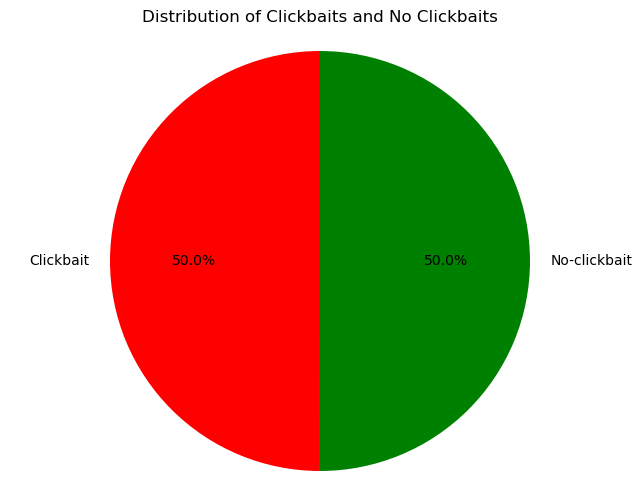


NaN titles dropped: False

Empty titles dropped: 0

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             4.631273  2.469242  38.795013  12.265831     0.721455  1.015306   
1             9.688356  2.866690  35.308957  10.295818     0.754047  1.074927   

              blank           numerical              letters             
               mean       std      mean       std       mean        std  
clickbait                                                                
0          7.194988  2.227746  0.510593  1.248460  43.426286  12.262935  
1          8.942684  2.660435  1.047003  1.427426  44.997312  12.532420  
With outliers:


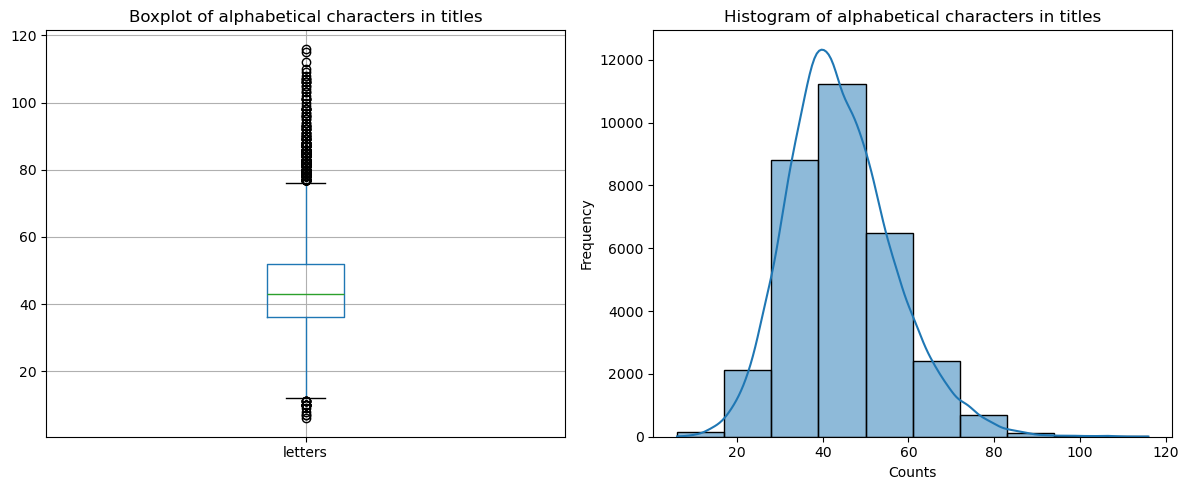

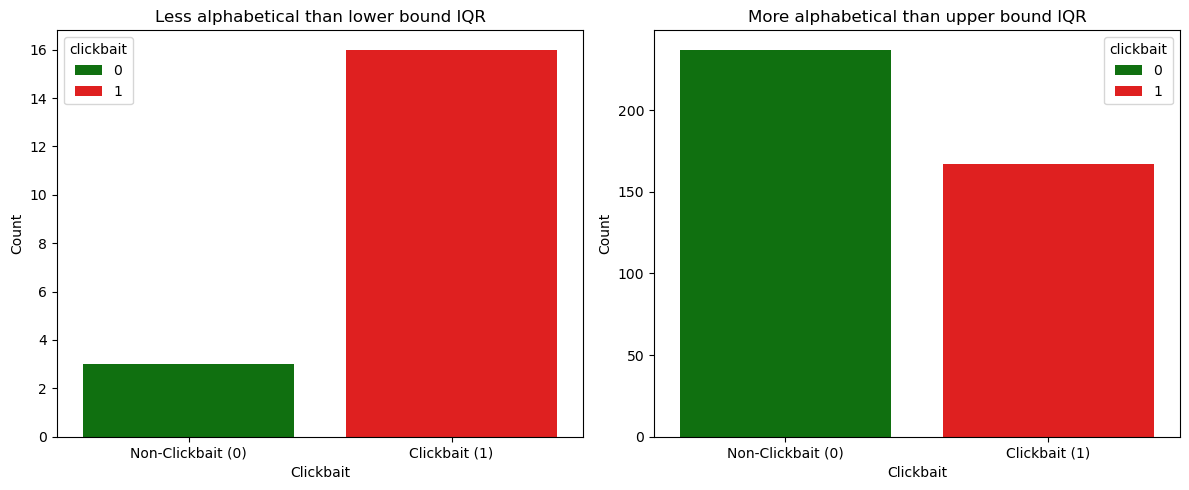

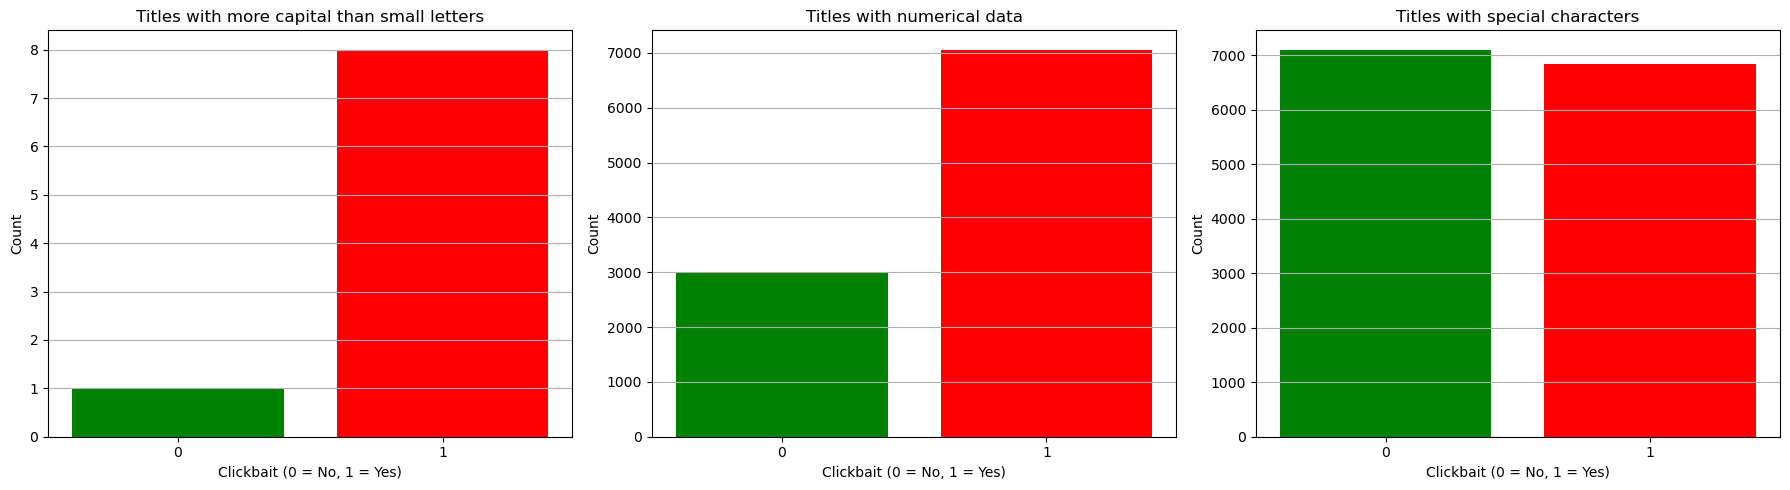

,title,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [190]:
df_1.head()
analyze_df(df_1)

 ## #2 Data source: kaggle 
https://www.kaggle.com/datasets/vikassingh1996/news-clickbait-dataset?select=train2.csv

In [191]:
df_news_2 = pd.read_csv("../data/train2.csv")
df_news_2['label'] = df_news_2['label'].apply(lambda x: 1 if x == 'clickbait' else 0)

df_news_2.rename(columns={'label': 'clickbait'}, inplace=True)
df_2 = df_news_2[['title', 'clickbait']]

Columns: ['title', 'clickbait']

Shape: (21029, 2)
Number of clickbaits: 4291
Number of no-clickbaits: 16738


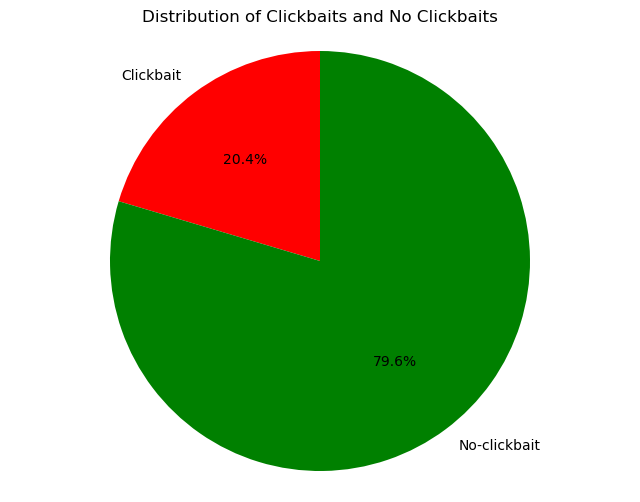


NaN titles dropped: False

Empty titles dropped: 0

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             7.007827  7.600632   54.32005  77.619362     1.817242  2.488330   
1             7.541133  8.086558   52.29457  88.087041     1.744349  2.739785   

               blank            numerical              letters             
                mean        std      mean       std       mean        std  
clickbait                                                                  
0          11.277453  15.941286  0.562254  1.518829  61.327877  83.707279  
1          11.496854  18.443404  0.805407  1.672381  59.835703  94.374176  
With outliers:


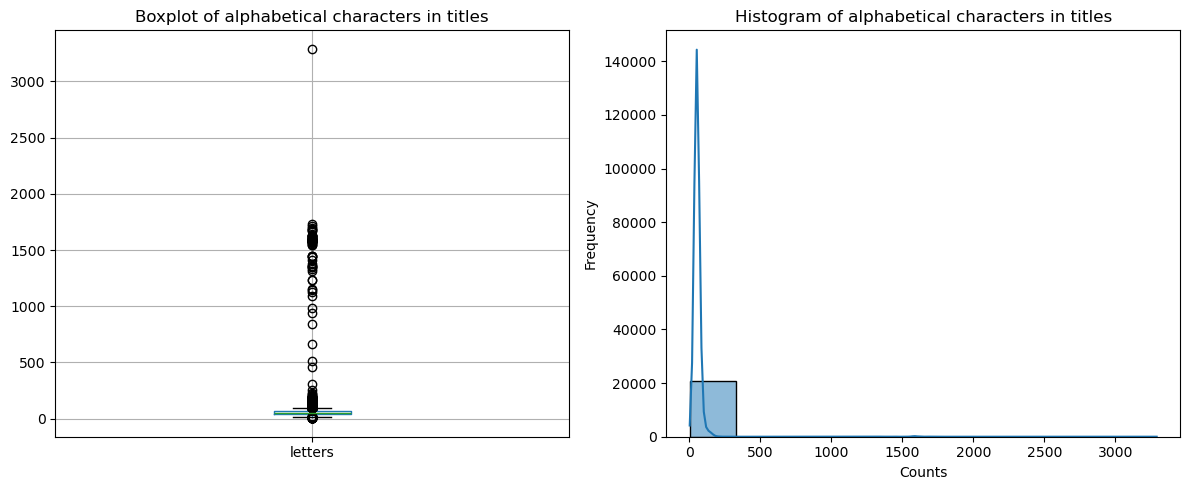

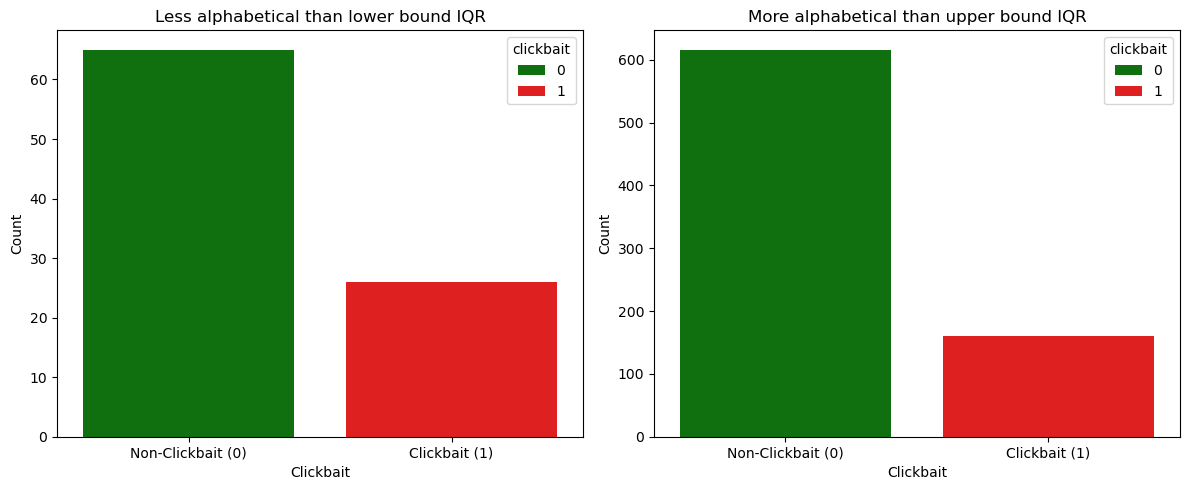

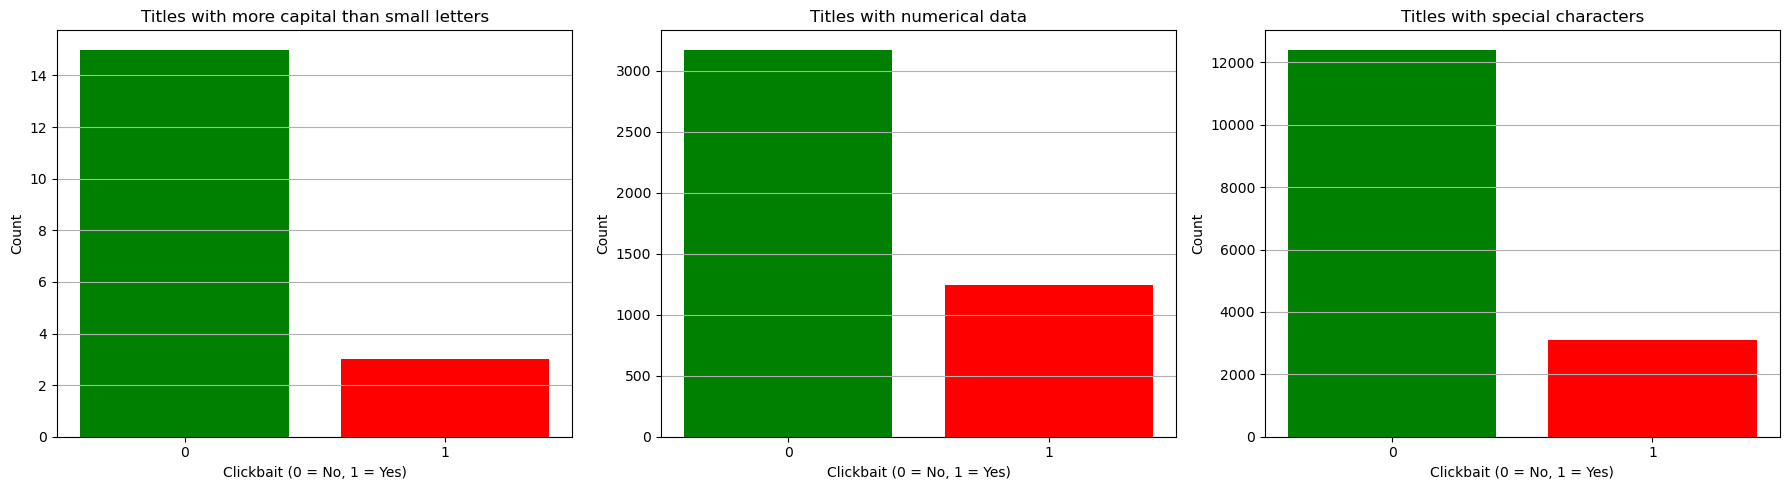

In [192]:
df_2.head()
df_2 = analyze_df(df_2)

 ## #3 Data source: clickbait challenge 
https://webis.de/events/clickbait-challenge/shared-task.html

In [193]:
file_path = '../data/clickbait17-train-170331/instances.jsonl'

# Read the JSON data from the file
with open(file_path, 'rb') as file:
    data_df = pd.read_json(file,lines=True)

file_path = '../data/clickbait17-train-170331/truth.jsonl'

# Read the JSON data from the file
with open(file_path, 'rb') as file:
    labels = pd.read_json(file,lines=True)
    
labels = labels[["id", "truthClass"]]
data_df = data_df[["id", "targetTitle"]]

df_3 = pd.merge(data_df, labels, left_on='id', right_on='id', how='left')
df_3['truthClass'] = df_3['truthClass'].apply(lambda x: 1 if x == 'clickbait' else 0)
df_3.rename(columns={'targetTitle': 'title', 'truthClass': 'clickbait'}, inplace=True)
df_3 = df_3[["title", "clickbait"]]

# b)

file_path = '../data/clickbait17-validation-170630/instances.jsonl'

# Read the JSON data from the file
with open(file_path, 'rb') as file:
    data_df = pd.read_json(file,lines=True)

file_path = '../data/clickbait17-validation-170630/truth.jsonl'

# Read the JSON data from the file
with open(file_path, 'rb') as file:
    labels = pd.read_json(file,lines=True)
    
labels = labels[["id", "truthClass"]]
data_df = data_df[["id", "targetTitle"]]

df_4 = pd.merge(data_df, labels, left_on='id', right_on='id', how='left')
df_4['truthClass'] = df_4['truthClass'].apply(lambda x: 1 if x == 'clickbait' else 0)
df_4.rename(columns={'targetTitle': 'title', 'truthClass': 'clickbait'}, inplace=True)
df_4 = df_4[["title", "clickbait"]]

Columns: ['title', 'clickbait']

Shape: (2459, 2)
Number of clickbaits: 762
Number of no-clickbaits: 1697


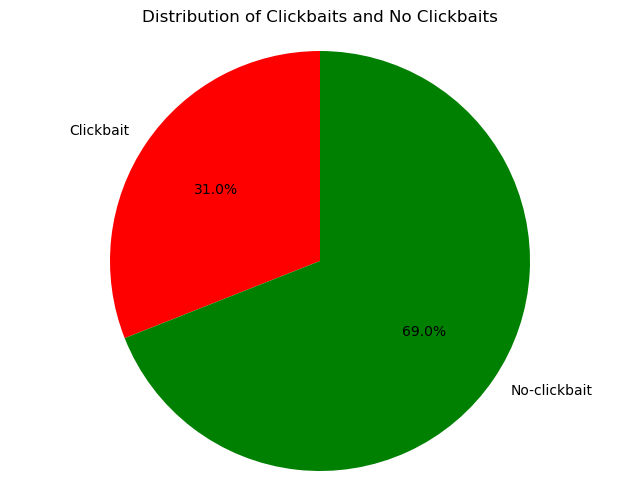


NaN titles dropped: False

Empty titles dropped: 0

Stats:
           char_capital             char_small             char_special  \
                  mean        std        mean         std         mean   
clickbait                                                                
0            12.619328  27.504610  130.041249  351.026795     3.608721   
1             9.329396  20.784241   91.223097  286.833934     2.627297   

                         blank            numerical               letters  \
                std       mean        std      mean       std        mean   
clickbait                                                                   
0          8.745693  26.816146  72.285494  1.395993  3.695667  142.660577   
1          6.886364  19.185039  59.307002  0.964567  2.810260  100.552493   

                       
                  std  
clickbait              
0          377.780763  
1          307.044879  
With outliers:


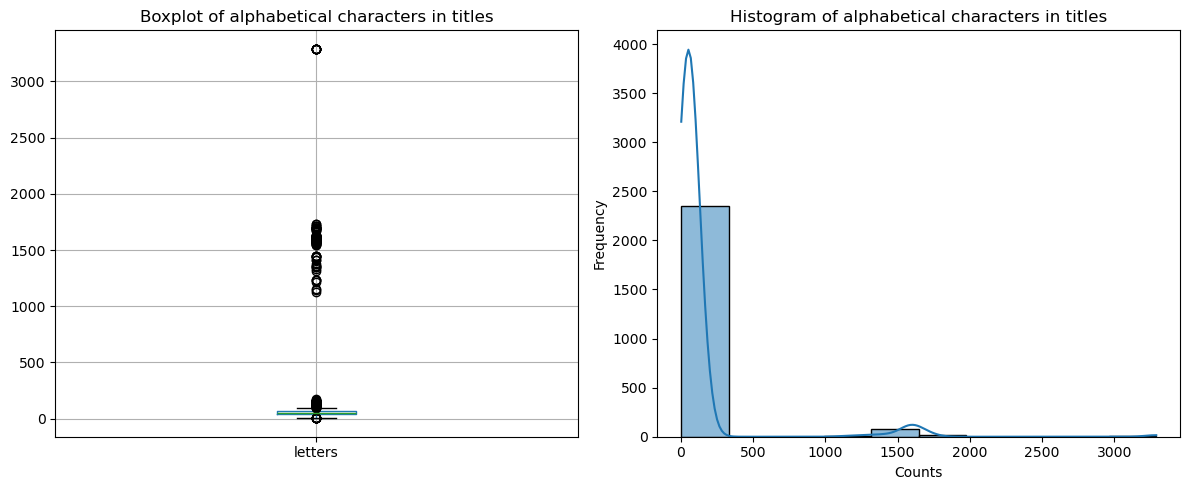

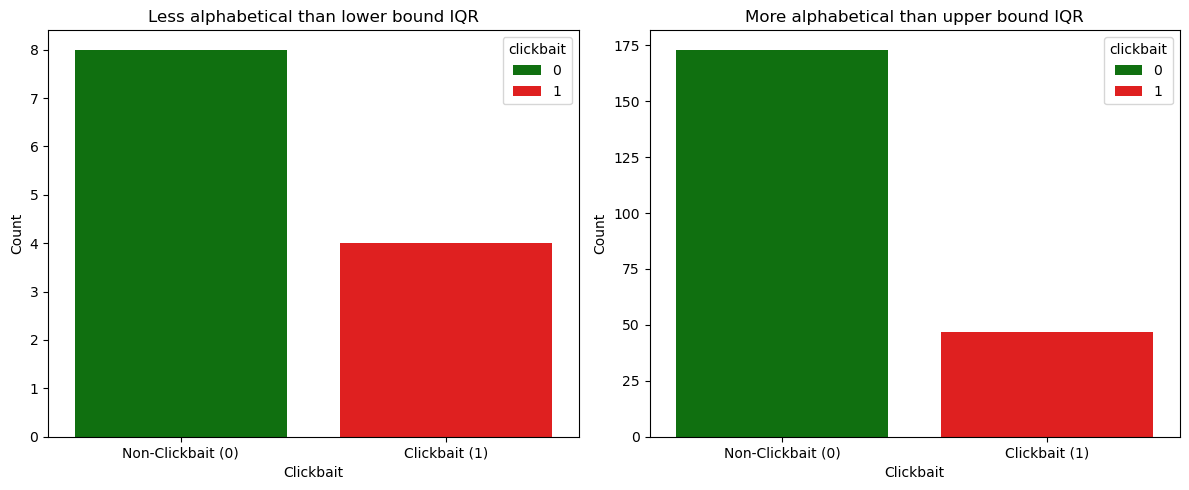

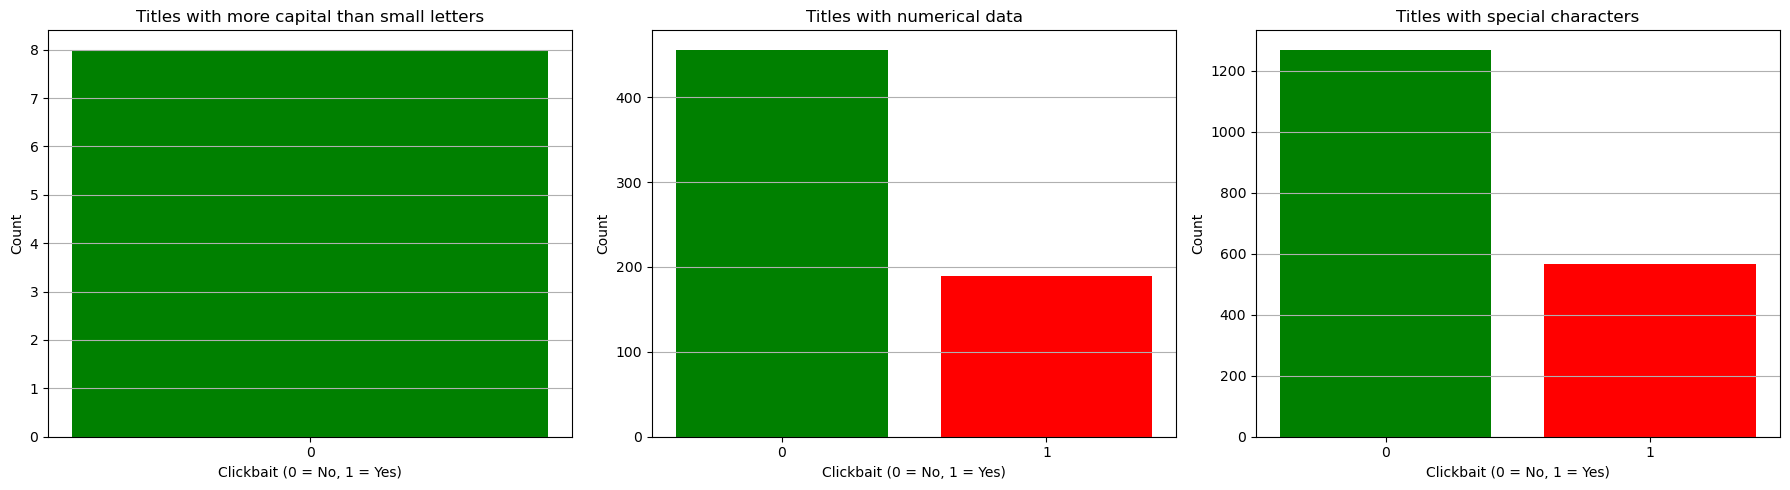

,title,clickbait
0,Apple gives back gigabytes: iOS 9 'app thinnin...,0
1,Emerging Markets Suffer Largest Outflow in Sev...,0
2,U.S. Soccer should start answering tough quest...,1
3,How theme parks like Disney World left the mid...,0
4,Warning labels on your light bulbs,1
...,...,...
2454,World's first penis transplant patient is set ...,1
2455,"At Women’s World Cup, Tie Leaves U.S. on Solid...",0
2456,Obama Defends Health Law Ahead of Supreme Cour...,0
2457,Deflating ‘Deflategate’,0


In [194]:
df_3.head()
analyze_df(df_3)

Columns: ['title', 'clickbait']

Shape: (19538, 2)
Number of clickbaits: 4761
Number of no-clickbaits: 14777


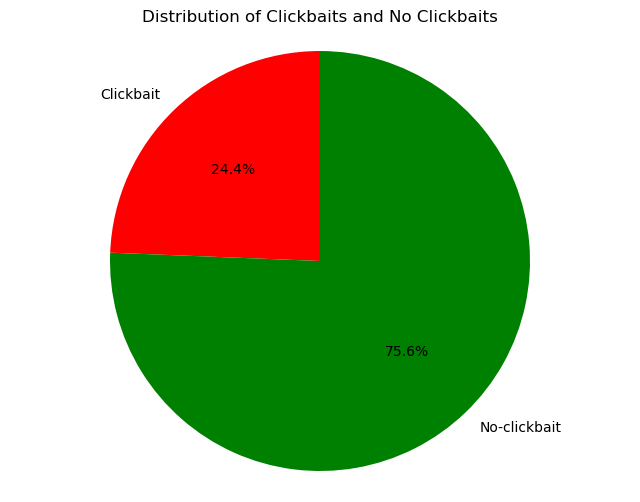


NaN titles dropped: False

Empty titles dropped: 0

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             6.774582  4.344514  51.272992  19.977313     1.674223  1.599813   
1             7.450116  6.022828  48.663516  37.736517     1.678639  2.401169   

               blank           numerical              letters             
                mean       std      mean       std       mean        std  
clickbait                                                                 
0          10.683562  4.321306  0.576572  1.338277  58.047574  20.276165  
1          10.822936  8.781232  0.808024  1.729534  56.116992  40.592543  
With outliers:


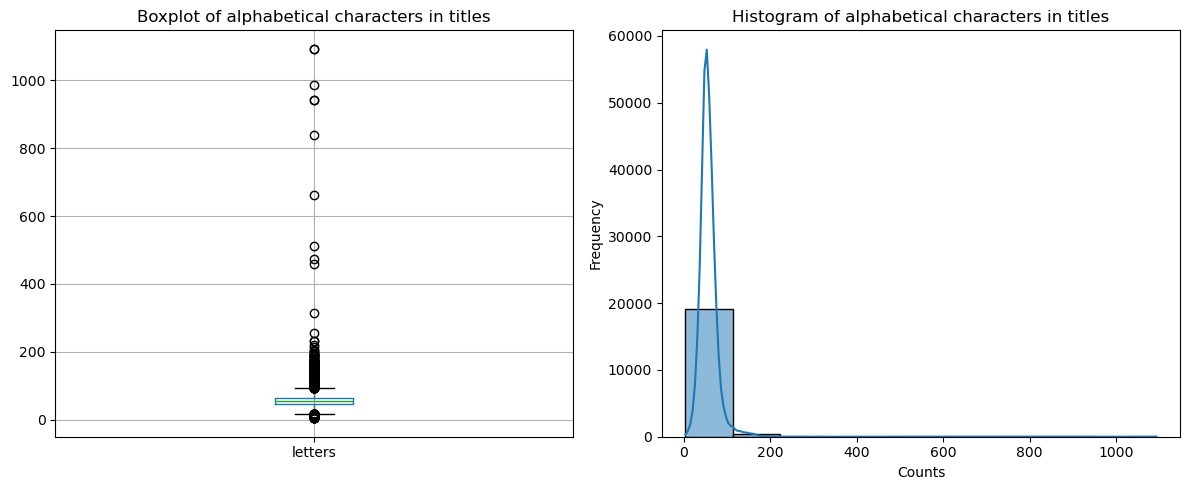

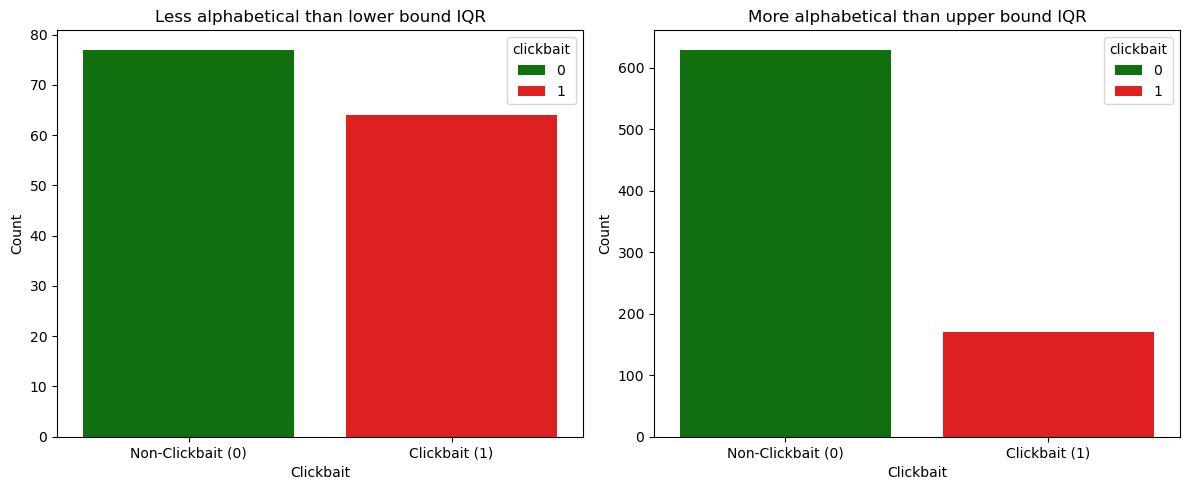

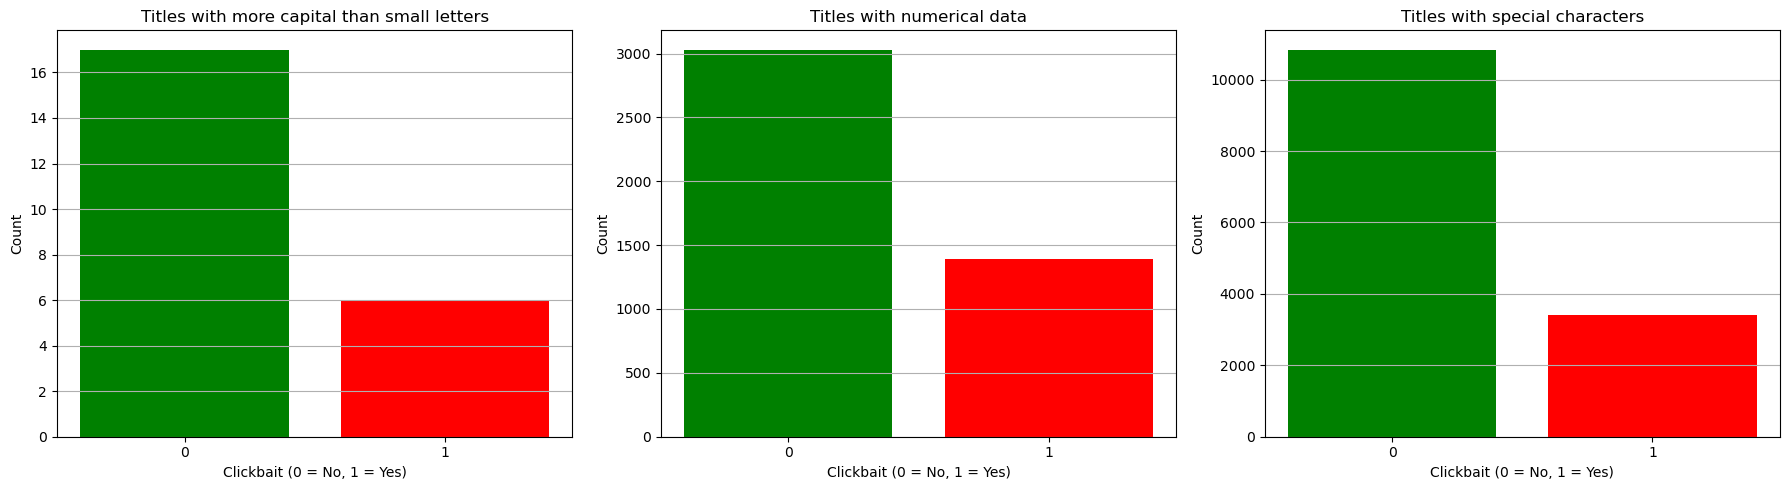

,title,clickbait
0,‘Inexcusable’ failures in UK’s response to mod...,0
1,Donald Trump Appoints Pro-Life Advocate as Ass...,1
2,The ‘forgotten’ Trump roast: Relive his brutal...,0
3,"Meet The Happiest Dog In The World, Maru The H...",1
4,Tokyo's subway is shut down amid fears over an...,0
...,...,...
19533,"NBC News Video See Brazil Soccer Team, Pilot’s...",0
19534,Politico Scoop: Eric Trump Killed Two Deer,1
19535,Frenchs Forest high school may relocate to mak...,0
19536,Los Angeles Rams Jeff Fisher May Think Danny W...,0


In [195]:
df_4.head()
analyze_df(df_4)

## Concatenate datasets

In [196]:
dfs = [
    df_1,
    df_2,
    df_3,
    df_4,
]

In [197]:
for df_ in dfs:
    print(df_.shape)

(32000, 2)
(21029, 2)
(2459, 2)
(19538, 2)


In [198]:
for i,df_ in enumerate(dfs):
    print("=========  " + str(i+1) +"- dataset =============")
    print(df_["clickbait"].value_counts())

=========  1- dataset =============
clickbait
0    16001
1    15999
Name: count, dtype: int64
=========  2- dataset =============
clickbait
0    16738
1     4291
Name: count, dtype: int64
=========  3- dataset =============
clickbait
0    1697
1     762
Name: count, dtype: int64
=========  4- dataset =============
clickbait
0    14777
1     4761
Name: count, dtype: int64


In [199]:
df_merged = pd.concat([df_1,df_2,df_3,df_4])

Columns: ['title', 'clickbait']

Shape: (75026, 2)
Number of clickbaits: 25813
Number of no-clickbaits: 49213


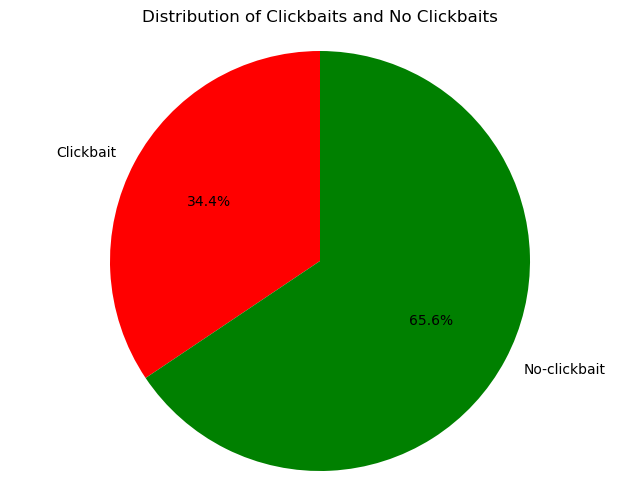


NaN titles dropped: False

Empty titles dropped: 0

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             6.358584  7.475663  50.968423  82.048450     1.479792  2.497756   
1             8.907992  6.039235  42.246271  64.564493     1.144501  2.167239   

               blank            numerical              letters             
                mean        std      mean       std       mean        std  
clickbait                                                                  
0          10.307581  16.930298  0.578506  1.524595  57.327007  88.280421  
1          10.016426  13.510049  0.960330  1.589050  51.154883  69.091152  
With outliers:


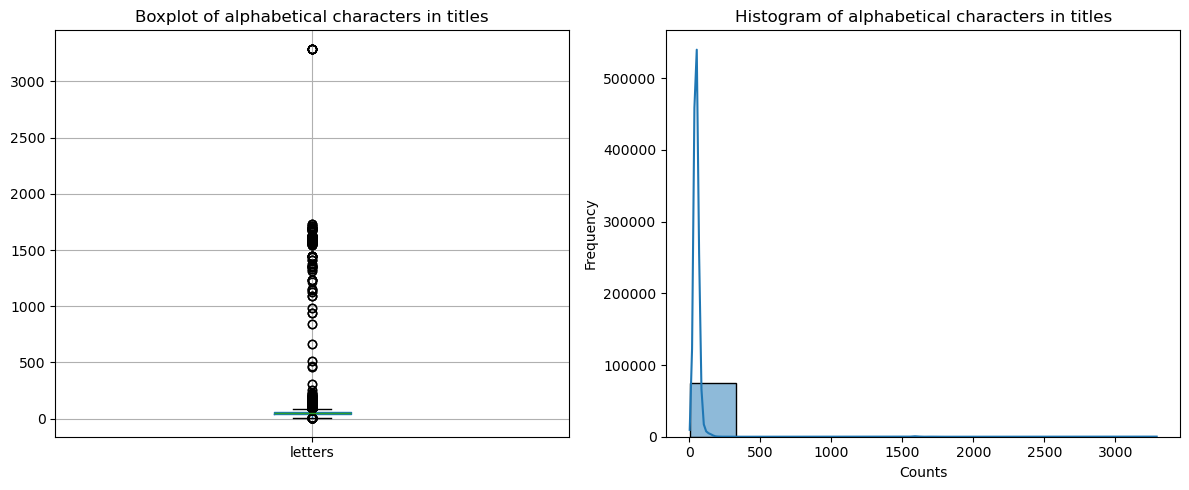

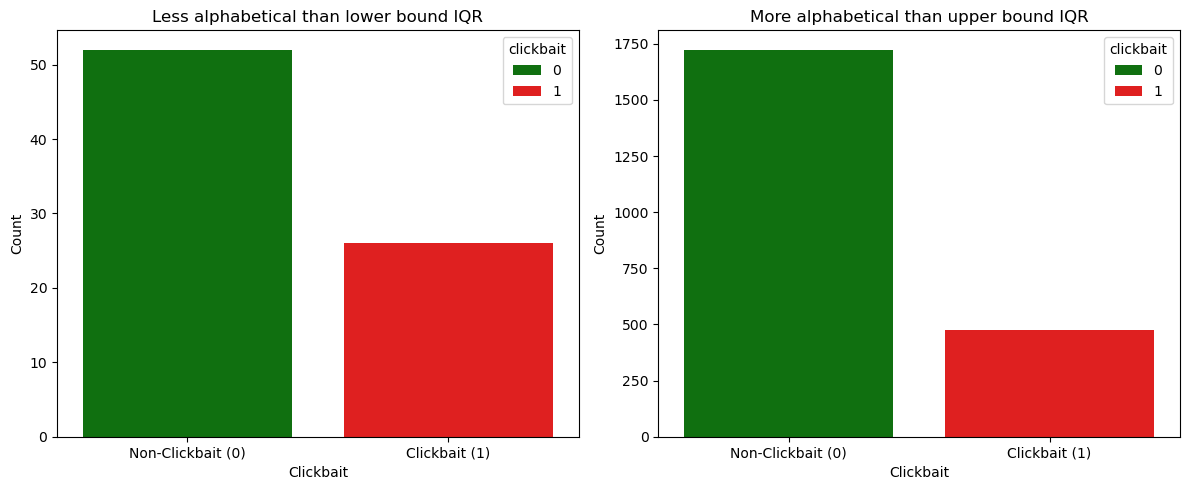

Without outliers:


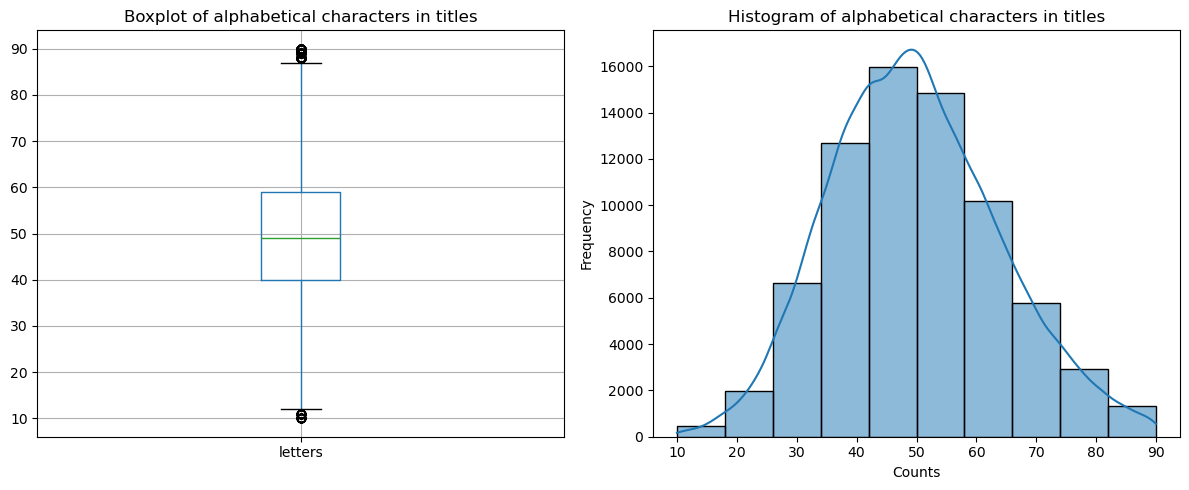

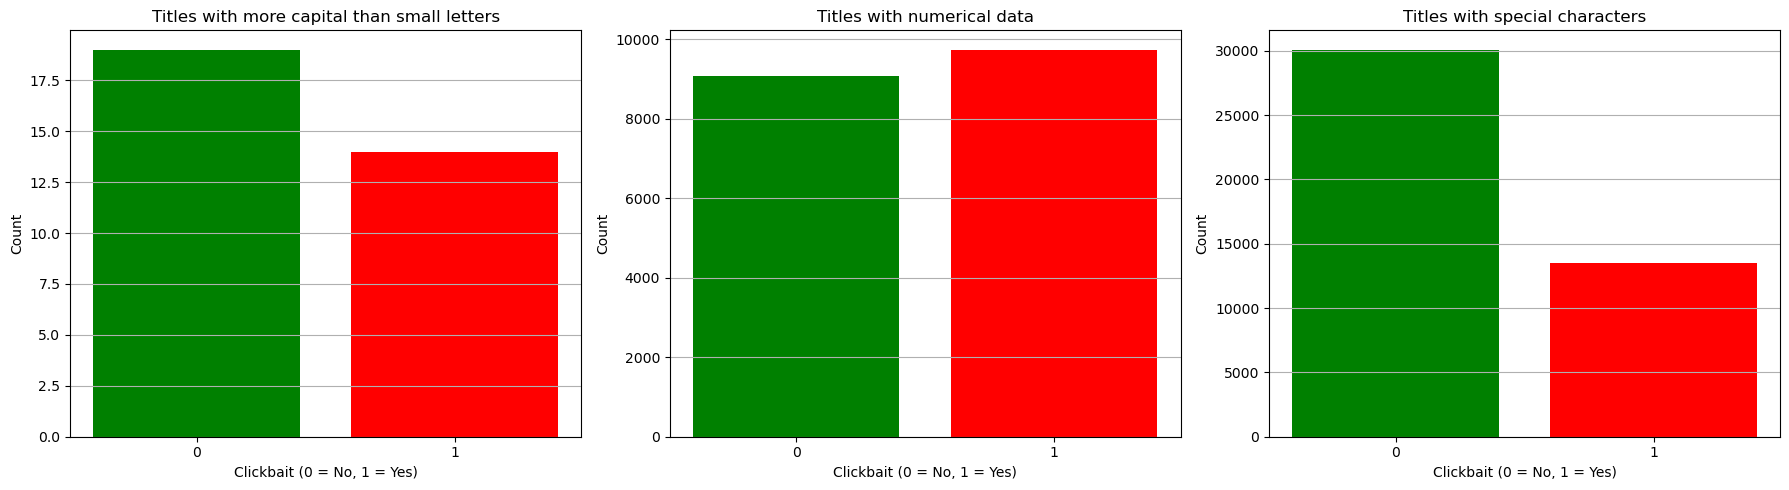

In [200]:
df_merged = analyze_df(df_merged, delete_outliers=DF_MERGED_DELETE_OUTLIERS)

In [201]:
df_merged.to_csv("../data/merged_all_datasets.csv", index=False)

Columns: ['title', 'clickbait']

Shape: (72750, 2)
Number of clickbaits: 25313
Number of no-clickbaits: 47437


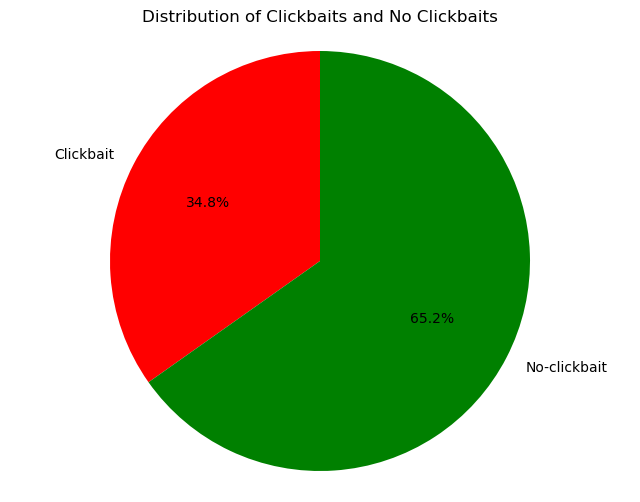


NaN titles dropped: False

Empty titles dropped: 0

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             5.994266  3.870839  44.708287  13.546215     1.327171  1.452195   
1             8.728321  3.838251  38.774227  12.620091     1.052108  1.315122   

              blank           numerical              letters             
               mean       std      mean       std       mean        std  
clickbait                                                                
0          9.017160  3.047997  0.525497  1.268712  50.702553  14.189372  
1          9.295658  2.909055  0.942322  1.452604  47.503180  13.899341  
With outliers:


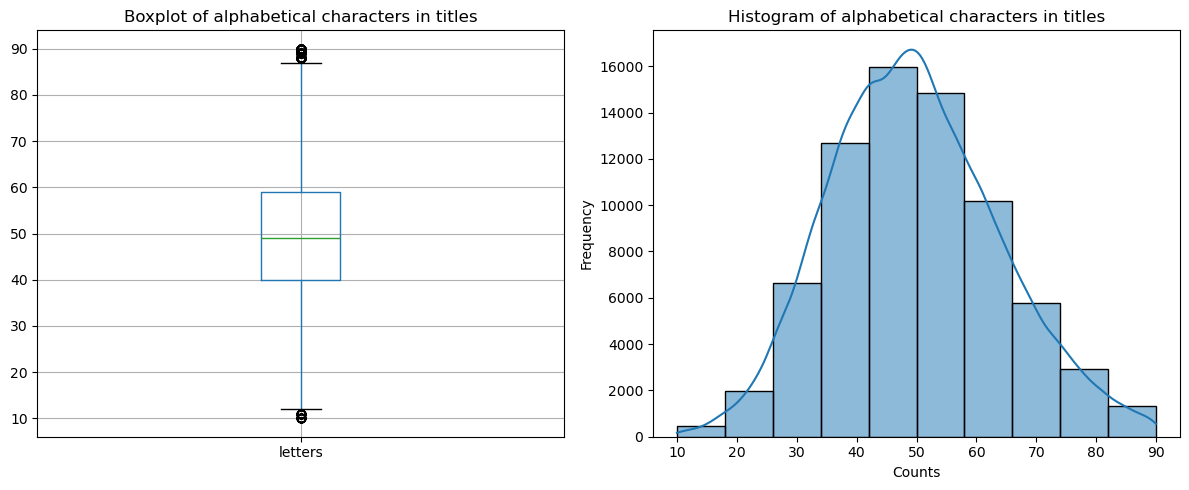

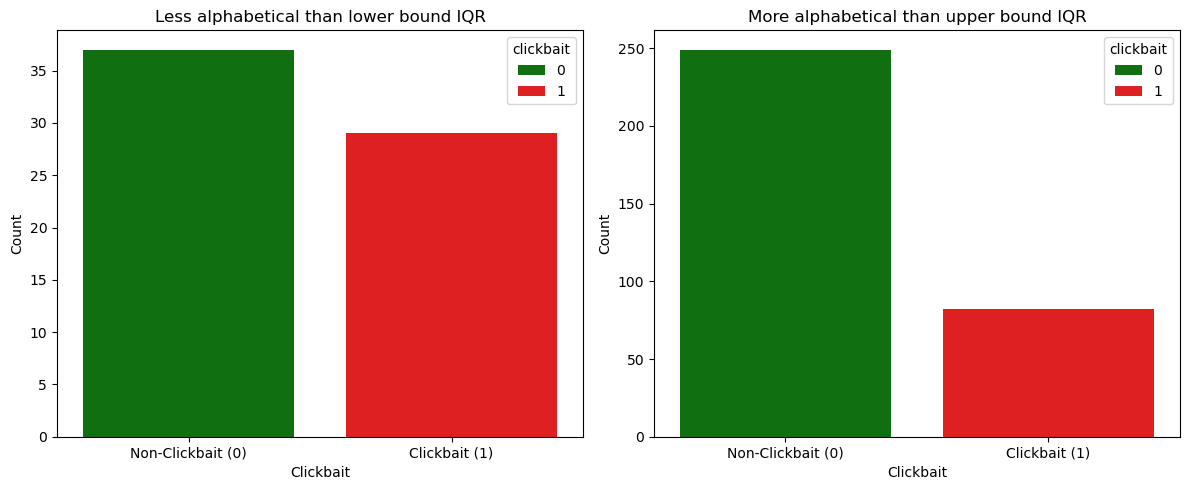

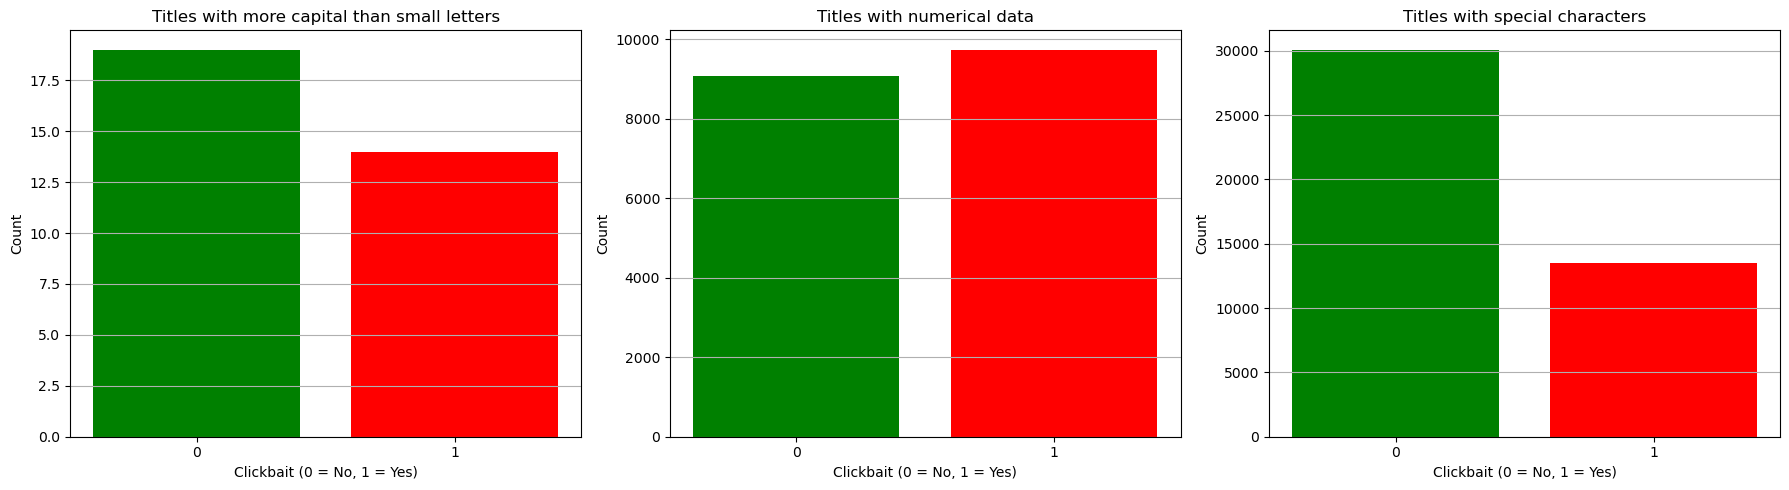

,title,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
19533,"NBC News Video See Brazil Soccer Team, Pilot’s...",0
19534,Politico Scoop: Eric Trump Killed Two Deer,1
19535,Frenchs Forest high school may relocate to mak...,0
19536,Los Angeles Rams Jeff Fisher May Think Danny W...,0


In [202]:
analyze_df(df_merged)

In [203]:
df_0_huge = df_merged[df_merged['clickbait'] == 0].sample(n=20000, random_state=42)
df_1_huge = df_merged[df_merged['clickbait'] == 1].sample(n=20000, random_state=42)
df_balanced_huge = pd.concat([df_0_huge, df_1_huge])

df_balanced_huge.to_csv("../data/merged_datasetes_balanced_huge.csv", index=False)

In [204]:
df_0 = df_merged[df_merged['clickbait'] == 0].sample(n=10000, random_state=42)
df_1 = df_merged[df_merged['clickbait'] == 1].sample(n=10000, random_state=42)

df_balanced = pd.concat([df_0, df_1])

In [205]:
df_balanced.to_csv("../data/merged_datasetes_balanced.csv", index=False)

## + Dataset with body: clickbait challange
https://webis.de/events/clickbait-challenge/shared-task.html

In [206]:
def load_data_cc(name, columns=[]):
    """
    loads data from clickbait challenge webis corpus
    
    name (str): name of the folder
    columns (list): list of columns names to extract apart from 'id' and 'targetTitle'
    """
    data_file_path = f'../data/{name}/instances.jsonl'
    with open(data_file_path, 'rb') as file:
        data_df = pd.read_json(file,lines=True)

    target_file_path = f'../data/{name}/truth.jsonl'
    with open(target_file_path, 'rb') as file:
        labels = pd.read_json(file,lines=True)
    
    data_df = data_df[["id", "targetTitle"] + columns]
    labels = labels[["id", "truthClass"]]

    df = pd.merge(data_df, labels, on='id', how='left')
    df.drop(['id'], axis=1, inplace=True)
    df['truthClass'] = df['truthClass'].apply(lambda x: 1 if x == 'clickbait' else 0)
    df.rename(columns={'targetTitle': 'title', 'truthClass': 'clickbait'}, inplace=True)
    return df

In [207]:
files = ["clickbait17-train-170331", "clickbait17-test-170720", "clickbait17-validation-170630"]
body_dfs = []
for filename in files:
    part_df = load_data_cc(filename, columns=["targetParagraphs"])
    part_df['body'] = part_df['targetParagraphs'].apply(lambda x: " ".join(x))
    part_df = part_df[['title', 'body', 'clickbait']]
    body_dfs.append(part_df)
df_body = pd.concat(body_dfs).reset_index(drop=True)

In [208]:
df_body['clickbait'].value_counts()

clickbait
0    30938
1    10038
Name: count, dtype: int64

In [209]:
df_body.to_csv("../data/cc_dataset.csv", index=False)

In [210]:
df_00 = df_body[df_body['clickbait'] == 0].sample(n=10000, random_state=37)
df_01 = df_body[df_body['clickbait'] == 1].sample(n=10000, random_state=37)

df_body_balanced = pd.concat([df_00, df_01])

In [211]:
df_body_balanced.to_csv("../data/cc_dataset_balanced.csv", index=False)

## Clickbait spoiling dataset

https://pan.webis.de/semeval23/pan23-web/clickbait-challenge.html

In [212]:
"""
Vocab:
task 1: spoiler type classification
task 2: spoiler generation / extraction

Columns:
targetTitle: The title of the linked web page.
targetParagraphs: The main content of the linked web page. Consists of the paragraphs of manually extracted main content.
humanSpoiler: The human generated spoiler (abstractive) for the clickbait post from the linked web page. Beware, there is a lot of missing values.
spoiler: The human extracted spoiler for the clickbait post from the linked web page.
spoilerPositions: The position of the human extracted spoiler for the clickbait post from the linked web page.
tags: The spoiler type (might be "phrase", "passage", or "multi") that is to be classified in task 1 (spoiler type classification).

How to use spoilerPositions:
if `data['spoilerPositions'][0]` is `[[[3, 151], [3, 186]]]`,
then `data['targetParagraphs'][0][3][151:186]` equals `data['spoiler']`
"""

'\nVocab:\ntask 1: spoiler type classification\ntask 2: spoiler generation / extraction\n\nColumns:\ntargetTitle: The title of the linked web page.\ntargetParagraphs: The main content of the linked web page. Consists of the paragraphs of manually extracted main content.\nhumanSpoiler: The human generated spoiler (abstractive) for the clickbait post from the linked web page. Beware, there is a lot of missing values.\nspoiler: The human extracted spoiler for the clickbait post from the linked web page.\nspoilerPositions: The position of the human extracted spoiler for the clickbait post from the linked web page.\ntags: The spoiler type (might be "phrase", "passage", or "multi") that is to be classified in task 1 (spoiler type classification).\n\nHow to use spoilerPositions:\nif `data[\'spoilerPositions\'][0]` is `[[[3, 151], [3, 186]]]`,\nthen `data[\'targetParagraphs\'][0][3][151:186]` equals `data[\'spoiler\']`\n'

In [213]:
names = ['train', 'validation']
spoil_dfs = []
for name in names:
    data_file_path = f'../../data/spoiling-clickbait-22/{name}.jsonl'
    with open(data_file_path, 'rb') as file:
        part_df = pd.read_json(file,lines=True)

    part_df['humanSpoiler'] = part_df['provenance'].apply(lambda x: x['humanSpoiler'])
    part_df = part_df[["targetTitle", "targetParagraphs", "humanSpoiler", "spoiler", "spoilerPositions", "tags"]]
    spoil_dfs.append(part_df)
spoil_df = pd.concat(spoil_dfs).reset_index(drop=True)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/spoiling-clickbait-22/train.jsonl'

In [37]:
spoil_df.to_csv("../data/spoiling_data.csv", index=False)